<h1><center>DOUBLE DEEP Q-LEARNING</center></h1>

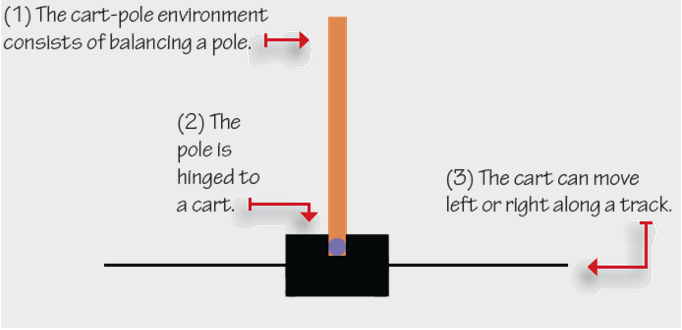

In [20]:
import numpy as np
import random
import gym
from collections import deque
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Activation
from keras.optimizers import Adam 

EVIRONMENT_NAME = "CartPole-v1"

In [21]:
#Experience Replay memory: experiences are staored  
#as tuples of (state, action, reward, next_state, done)
class Memory:
  def __init__(self, capacity = 2000):
       self.buffer = deque(maxlen = capacity)
       self.capacity = capacity 

  def append(self, experience):
      self.buffer.append(experience)     

  def sample(self, batch_size):
      return random.sample(self.buffer, batch_size)  

In [25]:
class DQN_Agent:
    def __init__(self, env, discount_rate = 0.99, 
                 lr = 0.001, batch_size = 64, 
                 epsilon_decay = 0.999, epsilon_min = 0.01):
        self.env = env
        self.state_size = env.observation_space.shape[0]
        self.discount_rate = discount_rate
  
        self.epsilon = 1.
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        self.MODEL_NAME = "dqn_cartPole-v1.h5"

        self.memory = Memory()

        self.dqn_model = self.create_model(lr, "DDQN")

    def load_model(self):
        self.dqn_model = load_model(self.MODEL_NAME)
    
    #NN model approximating Q-value
    def create_model(self, lr, name):
        inputs = Input(shape=(self.state_size,))
        fc1 = Dense(16, activation= 'relu', kernel_initializer= 'he_uniform')(inputs)
        fc2 = Dense(32, activation= 'relu', kernel_initializer= 'he_uniform')(fc1)
        outputs = Dense(self.env.action_space.n, activation= 'linear', kernel_initializer= 'he_uniform')(fc2)
        model = Model(inputs= inputs, outputs= outputs, name= name)
        model.compile(loss= 'mse', optimizer= Adam(lr = lr))        
        return model

    #Epsilon greedy policy (behaviour policy)
    def epsilon_greedy_action(self, state):
        if np.random.rand() <= self.epsilon:
            #Exploration 
            action = np.random.choice(self.env.action_space.n)
        else:
            #Exploitation 
            q = self.dqn_model.predict(state)
            action = np.argmax(q[0])
        return action
    
    def act(self, state):
        q = self.dqn_model.predict(np.reshape(state,[1, self.state_size]))
        action = np.argmax(q[0])
        return action        
    
    #Learn from a mini-batch of experiences
    def learn(self):
        #sample memory for replay
        batch = self.memory.sample(self.batch_size)
        
        
        states = [experience[0] for experience in batch]
        actions = [experience[1] for experience in batch]        
        rewards = [experience[2] for experience in batch]
        next_states = [experience[3] for experience in batch]
        dones = [experience[4] for experience in batch]

        states = np.reshape(states, [self.batch_size, self.state_size])
        next_states = np.reshape(next_states, [self.batch_size, self.state_size])
       
        #Use dqn model to predict Q-value of current states in mini-batch
        q_states = self.dqn_model.predict(states)

        #Use dqn model to predict Q-value of next states in mini-batch
        q_target_next_states = self.dqn_model.predict(next_states)

        q_optimal = q_states
        
        #Calculate Q-value targets based on Q-Learning off-policy date rule
        #𝑞(𝑠, 𝑎) += 𝛼(𝑅+ 𝑚𝑎𝑥𝑎′ 𝑞(𝑠′, 𝑎′)− 𝑞(𝑠, 𝑎))
        for i in range(self.batch_size):
            if dones[i]:
                #for terminal states target is immediate reward 
                #in current time step 
                q_optimal[i][actions[i]] = rewards[i]
            else:
                #update rule: 𝑞(𝑠, 𝑎) += 𝛼(𝑅+ 𝑚𝑎𝑥𝑎′ 𝑞(𝑠′, 𝑎′)− 𝑞(𝑠, 𝑎))
                max_next_action = np.argmax(q_target_next_states[i])
                q_optimal[i][actions[i]] = rewards[i] + \
                   self.discount_rate * (q_target_next_states[i][max_next_action])

        #train the DQN model            
        self.dqn_model.fit(states, q_optimal, batch_size = self.batch_size,
                       epochs=1, verbose=0)            

    def train(self, max_episodes):
        history = []
        
        for e in range(max_episodes):
            done = False
            episode_total = 0
            state = env.reset()

            while not done:
                 #get next action following behaviour policy 
                 action = self.epsilon_greedy_action(np.reshape(state, [1, self.state_size]))
                 
                 #interact with environment   
                 next_state, reward, done, info = env.step(action)
                 reward = reward if not done or episode_total == 499 else -100

                 #append experience to replay memory
                 self.memory.append((state, action, reward, next_state, done))
                
                 #exploration deacy 
                 if self.epsilon > self.epsilon_min:
                    self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
                                       
                 if len(self.memory.buffer) >= 1000:
                    #train the DQN model 
                    self.learn()
                    
                 episode_total += reward
                 state = next_state

            episode_total = episode_total if episode_total == 500 else episode_total + 100
            history.append(episode_total)
            print("episode:", e, "  episode_total:", episode_total)

        rewards_of_thousand_episodes = np.split(np.array(history), max_episodes/10)  
        mean_rewards = []
        for r in rewards_of_thousand_episodes:
            mean_rewards.append(sum(r/10))  
                
        plt.plot(mean_rewards)
        plt.xlabel("episodes (ten episodes)")
        plt.ylabel("rewards")
        plt.show()              
            
        self.dqn_model.save(self.MODEL_NAME)     



episode: 0   episode_total: 20.0
episode: 1   episode_total: 7.0
episode: 2   episode_total: 12.0
episode: 3   episode_total: 14.0
episode: 4   episode_total: 14.0
episode: 5   episode_total: 14.0
episode: 6   episode_total: 13.0
episode: 7   episode_total: 9.0
episode: 8   episode_total: 22.0
episode: 9   episode_total: 14.0
episode: 10   episode_total: 22.0
episode: 11   episode_total: 12.0
episode: 12   episode_total: 38.0
episode: 13   episode_total: 13.0
episode: 14   episode_total: 10.0
episode: 15   episode_total: 28.0
episode: 16   episode_total: 33.0
episode: 17   episode_total: 12.0
episode: 18   episode_total: 18.0
episode: 19   episode_total: 25.0
episode: 20   episode_total: 23.0
episode: 21   episode_total: 9.0
episode: 22   episode_total: 19.0
episode: 23   episode_total: 11.0
episode: 24   episode_total: 16.0
episode: 25   episode_total: 15.0
episode: 26   episode_total: 11.0
episode: 27   episode_total: 15.0
episode: 28   episode_total: 10.0
episode: 29   episode_total

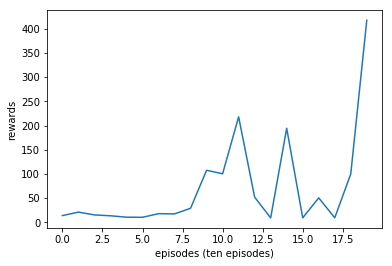

In [23]:
env = gym.make(EVIRONMENT_NAME)
agent = DQN_Agent(env)
agent.train(200) 

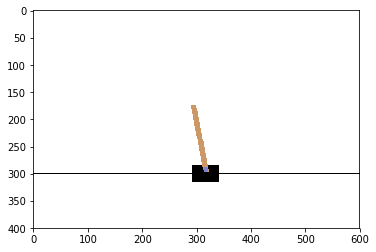

In [11]:
import gym
from IPython import display
import matplotlib.pyplot as plt
import time

%matplotlib inline

MAX_EPISODES = 10

env = gym.make(EVIRONMENT_NAME)
for episode in range(3):
    state = env.reset()
    done = False
    steps = 0
    rewards = 0
    while not done:
       plt.imshow(env.render(mode='rgb_array'))
       display.clear_output(wait=True)
       display.display(plt.gcf())
       _, reward, done, _ = env.step(env.action_space.sample())
       time.sleep(0.005)
       rewards+= reward 
    print('end of episode: %d score: %.2f'%(episode, rewards))
    time.sleep(3)
display.clear_output()    

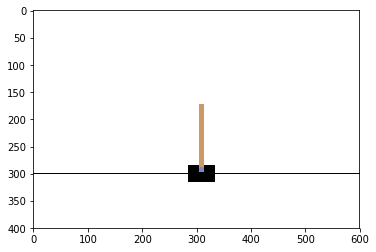

In [ ]:
import gym
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make(EVIRONMENT_NAME)
agent = DQN_Agent(env)
agent.load_model()

for episode in range(3):
    state = env.reset()
    done = False
    rewards = 0
    while not done and rewards < 500:
        plt.imshow(env.render(mode='rgb_array'))
        display.clear_output(wait=True)
        display.display(plt.gcf())
        action = agent.act(state)
        state, reward, done, _ = env.step(action)
        rewards+=1
        if rewards % 20 == 0:
           print('episode: %d score: %.2f'%(episode, rewards))
           time.sleep(1) 
    time.sleep(1)
display.clear_output()    